In [83]:
import os
import numpy as np
import tqdm
import json
import random
import time
import multiprocessing
from ember_features import PEFeatureExtractor
from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import copy
import matplotlib.pyplot as plt
import scipy as stats
from sklearn.manifold import TSNE
from collections import defaultdict
import seaborn as sns
import hdbscan
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['font.size'] = 18
#plt.rcParams['font.family'] = "serif"
tdir = 'in'
major = 5.0
minor = 3.0
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor

np.random.RandomState(42);

In [3]:
all_task_months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
                   '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12']

malware_family_sample_count = {}
goodware_family_sample_count = {}

malware_family_samples = {}

others_family = {}

standardization = StandardScaler()

#task_based_malware_samples = {}
for task in range(0,len(all_task_months)):
    
    current_task = all_task_months[task]
    task_months = all_task_months[:task+1]
    
    
    data_dir = '/home/mr6564/continual_research/month_based_processing_with_family_labels/' + str(current_task) + '/'
    
    #print(f'Processing data for task {current_task}')
    Y_family_labels_file = data_dir + 'task_family_labels.npz'
    Y_fam_labels_ = np.load(Y_family_labels_file)
    Y_fam_labels = Y_fam_labels_['family_labels']

    y_path = os.path.join(data_dir, "y_train.dat")
    X_path = os.path.join(data_dir, "X_train.dat")
    
    
    y_ = np.memmap(y_path, dtype=np.float32, mode="r")
    N = y_.shape[0]
    
    ndim = 2381
    X_ = np.memmap(X_path, dtype=np.float32, mode="r", shape=(N, ndim))    
    #print(np.unique(y_))
    
    Y_family_labels_file = data_dir + 'task_family_labels.npz'
    Y_fam_labels_ = np.load(Y_family_labels_file)
    Y_fam_labels = Y_fam_labels_['family_labels']
    
    ##standardize 
    standard_scaler = standardization.partial_fit(X_)
    X_ = standard_scaler.transform(X_)
    X_ = np.array(X_, np.float32)
    print(f'task {current_task} samples {len(X_)}')
    
    goodware_indices = []
    malware_indices = []
    
    others_family_samples = []
    
    malware_task_family_samples = defaultdict(list)
    
    for ind, i in enumerate(y_):
        if i == 0:
            goodware_indices.append(ind)
        elif i == 1:
            malware_indices.append(ind)
            if Y_fam_labels[ind] == '':
                others_family_samples.append(X_[ind])
            else:
                malware_task_family_samples[Y_fam_labels[ind]].append(X_[ind])
                
                
                #if Y_fam_labels[ind] not in malware_task_family_samples.keys():
                #    malware_task_family_samples[Y_fam_labels[ind]]= X_ind
                #else:
                #    malware_task_family_samples[Y_fam_labels[ind]].append(X_ind)
        else:
            pass
    
    malware_family_samples[task] = malware_task_family_samples
    others_family[task] = others_family_samples
    

    Y_families_malware = Y_fam_labels[malware_indices]
    Y_families_goodware = Y_fam_labels[goodware_indices]
    
    
    
    for yfam in Y_families_malware:
        if yfam in malware_family_sample_count.keys():
            malware_family_sample_count[yfam] += 1
        else:
            malware_family_sample_count[yfam] = 1
    
    
    for yfam in Y_families_goodware:
        if yfam in goodware_family_sample_count.keys():
            goodware_family_sample_count[yfam] += 1
        else:
            goodware_family_sample_count[yfam] = 1
            
            
print(len(malware_family_sample_count.keys()), len(goodware_family_sample_count.keys()))

task 2018-01 samples 84702
task 2018-02 samples 73456
task 2018-03 samples 56929
task 2018-04 samples 70962
task 2018-05 samples 63000
task 2018-06 samples 66195
task 2018-07 samples 70064
task 2018-08 samples 62118
task 2018-09 samples 85352
task 2018-10 samples 117222
task 2018-11 samples 100000
task 2018-12 samples 100000
2900 1


In [4]:
top_10 = ['xtrat', 'zbot', 'ramnit', 'sality', 'installmonster',\
              'zusy', 'emotet', 'vtflooder', 'others_family', 'fareit']

In [79]:
def get_IF_scores(data_X):

    # fit the model
    clf = IsolationForest(max_samples=len(data_X))
    clf.fit(data_X)
    scores_prediction = clf.decision_function(data_X)
    #y_pred = clf.predict(data_X)
    
    return scores_prediction

def get_HDBSCAN_IF_labels_scores(task_id, family_ind,
                                 min_cluster_size,
                                 min_samples,
                                 task_families_data):
    top_10 = ['xtrat', 'zbot', 'ramnit', 'sality', 'installmonster',\
              'zusy', 'emotet', 'vtflooder', 'others_family', 'fareit']
    all_task_months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
                   '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12']
    
    curr_task = all_task_months[task_id]
    family_name = top_10[family_ind]

    #print(f'task {curr_task} family name {family_name}')
    data_X = task_families_data[task_id][family_name]
    
    clf = hdbscan.HDBSCAN(min_cluster_size, min_samples)
    clf_labels = clf.fit(data_X)
    
    labels = clf_labels.labels_
    unique_labels = np.unique(labels)
    num_unique_labels = len(unique_labels)  
    
    
    outliers = len(np.where(labels == -1)[0])
    print(f'family {family_name} #of samples-outliers: {len(labels)} - {outliers}')
    print()
    ifScores = get_IF_scores(data_X)
    
    return ifScores, labels, num_unique_labels

In [73]:
mcsize, msam = 40, 2


anomaly_00, labels_00, num_labels_00 = get_HDBSCAN_IF_labels_scores(0, 6, mcsize, msam, malware_family_samples)
anomaly_01, labels_01, num_labels_01 = get_HDBSCAN_IF_labels_scores(0, 4, mcsize, msam, malware_family_samples)
anomaly_02, labels_02, num_labels_02 = get_HDBSCAN_IF_labels_scores(0, 5, mcsize, msam, malware_family_samples)

anomaly_10, labels_10, num_labels_10 = get_HDBSCAN_IF_labels_scores(1, 6, mcsize, msam, malware_family_samples)
anomaly_11, labels_11, num_labels_11 = get_HDBSCAN_IF_labels_scores(1, 4, mcsize, msam, malware_family_samples)
anomaly_12, labels_12, num_labels_12 = get_HDBSCAN_IF_labels_scores(1, 5, mcsize, msam, malware_family_samples)

anomaly_20, labels_20, num_labels_20 = get_HDBSCAN_IF_labels_scores(2, 6, mcsize, msam, malware_family_samples)
anomaly_21, labels_21, num_labels_21 = get_HDBSCAN_IF_labels_scores(2, 4, mcsize, msam, malware_family_samples)
anomaly_22, labels_22, num_labels_22 = get_HDBSCAN_IF_labels_scores(2, 5, mcsize, msam, malware_family_samples)


task 2018-01 family name emotet
#of outliers 245

task 2018-01 family name installmonster
#of outliers 506

task 2018-01 family name zusy
#of outliers 156

task 2018-02 family name emotet
#of outliers 91

task 2018-02 family name installmonster
#of outliers 384

task 2018-02 family name zusy
#of outliers 830

task 2018-03 family name emotet
#of outliers 171

task 2018-03 family name installmonster
#of outliers 191

task 2018-03 family name zusy
#of outliers 79




## Scatter Plot of Anomaly Scores - Colors w/ HDBSCAN labels

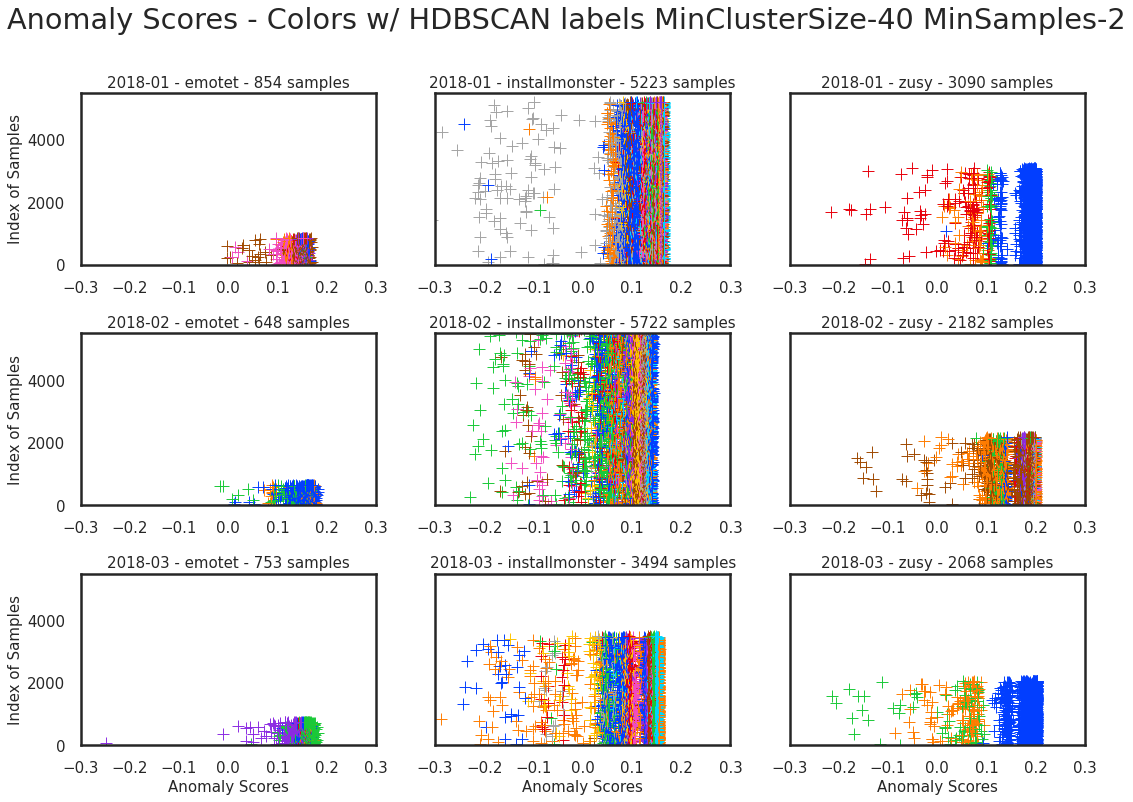

In [74]:
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
palette = sns.color_palette("bright")


save_file_name = f'TASK_IF_HDBSCAN_colors_STD_{mcsize}_{msam}.pdf'
figure, axis = plt.subplots(3, 3, figsize=(18, 12))

figure.suptitle(f'Anomaly Scores - Colors w/ HDBSCAN labels MinClusterSize-{mcsize} MinSamples-{msam}')


palette = sns.color_palette(sns.color_palette("bright", num_labels_00))
cluster_colors = [palette[l] for l in labels_00]
sns.scatterplot(ax=axis[0, 0], x=anomaly_00, y=[i for i in range(len(anomaly_00))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[0, 0].set_title(f"{all_task_months[0]} - {top_10[6]} - {len(anomaly_00)} samples", fontsize=15)
axis[0, 0].tick_params(labelsize=15)  
#axis[0, 0].set_xlabel("Anomaly Scores",fontsize=15)    
axis[0, 0].set_ylabel("Index of Samples",fontsize=15)    
axis[0, 0].set_xlim(-0.3, 0.3)
axis[0, 0].set_ylim(0, 5500)


palette = sns.color_palette(sns.color_palette("bright", num_labels_01))
cluster_colors = [palette[l] for l in labels_01]
sns.scatterplot(ax=axis[0, 1], x=anomaly_01, y=[i for i in range(len(anomaly_01))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[0, 1].set_title(f'{all_task_months[0]} - {top_10[4]} - {len(anomaly_01)} samples', fontsize=15)
axis[0, 1].tick_params(labelsize=15, labelleft=False, left=False)  
#axis[0, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[0, 1].set_ylabel(" ",fontsize=15)    
axis[0, 1].set_xlim(-0.3, 0.3)  
axis[0, 1].set_ylim(0, 5500)


palette = sns.color_palette(sns.color_palette("bright", num_labels_02))
cluster_colors = [palette[l] for l in labels_02]
sns.scatterplot(ax=axis[0, 2], x=anomaly_02, y=[i for i in range(len(anomaly_02))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[0, 2].set_title(f'{all_task_months[0]} - {top_10[5]} - {len(anomaly_02)} samples', fontsize=15)
axis[0, 2].tick_params(labelsize=15, labelleft=False, left=False)  
#axis[0, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[0, 2].set_ylabel(" ",fontsize=15)    
axis[0, 2].set_xlim(-0.3, 0.3)
axis[0, 2].set_ylim(0, 5500)


palette = sns.color_palette(sns.color_palette("bright", num_labels_10))
cluster_colors = [palette[l] for l in labels_10]
sns.scatterplot(ax=axis[1, 0], x=anomaly_10, y=[i for i in range(len(anomaly_10))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[1, 0].set_title(f'{all_task_months[1]} - {top_10[6]} - {len(anomaly_10)} samples', fontsize=15)
axis[1, 0].tick_params(labelsize=15)  
#axis[1, 0].set_xlabel("Anomaly Scores",fontsize=15)    
axis[1, 0].set_ylabel("Index of Samples",fontsize=15) 
axis[1, 0].set_xlim(-0.3, 0.3)
axis[1, 0].set_ylim(0, 5500)


palette = sns.color_palette(sns.color_palette("bright", num_labels_11))
cluster_colors = [palette[l] for l in labels_11]
sns.scatterplot(ax=axis[1, 1], x=anomaly_11, y=[i for i in range(len(anomaly_11))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[1, 1].set_title(f'{all_task_months[1]} - {top_10[4]} - {len(anomaly_11)} samples', fontsize=15)
axis[1, 1].tick_params(labelsize=15, labelleft=False, left=False)  
#axis[1, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[1, 1].set_ylabel(" ",fontsize=15) 
axis[1, 1].set_xlim(-0.3, 0.3)  
axis[1, 1].set_ylim(0, 5500)


palette = sns.color_palette(sns.color_palette("bright", num_labels_12))
cluster_colors = [palette[l] for l in labels_12]
sns.scatterplot(ax=axis[1, 2], x=anomaly_12, y=[i for i in range(len(anomaly_12))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[1, 2].set_title(f'{all_task_months[1]} - {top_10[5]} - {len(anomaly_12)} samples', fontsize=15)
axis[1, 2].tick_params(labelsize=15, labelleft=False, left=False)  
#axis[1, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[1, 2].set_ylabel(" ",fontsize=15) 
axis[1, 2].set_xlim(-0.3, 0.3)
axis[1, 2].set_ylim(0, 5500)

palette = sns.color_palette(sns.color_palette("bright", num_labels_20))
cluster_colors = [palette[l] for l in labels_20]
sns.scatterplot(ax=axis[2, 0], x=anomaly_20, y=[i for i in range(len(anomaly_20))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[2, 0].set_title(f'{all_task_months[2]} - {top_10[6]} - {len(anomaly_20)} samples', fontsize=15)
axis[2, 0].tick_params(labelsize=15)  
axis[2, 0].set_xlabel("Anomaly Scores",fontsize=15)    
axis[2, 0].set_ylabel("Index of Samples",fontsize=15) 
axis[2, 0].set_xlim(-0.3, 0.3)
axis[2, 0].set_ylim(0, 5500)


palette = sns.color_palette(sns.color_palette("bright", num_labels_21))
cluster_colors = [palette[l] for l in labels_21]
sns.scatterplot(ax=axis[2, 1], x=anomaly_21, y=[i for i in range(len(anomaly_21))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[2, 1].set_title(f'{all_task_months[2]} - {top_10[4]} - {len(anomaly_21)} samples', fontsize=15)
axis[2, 1].tick_params(labelsize=15, labelleft=False, left=False)  
axis[2, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[2, 1].set_ylabel(" ",fontsize=15) 
axis[2, 1].set_xlim(-0.3, 0.3)
axis[2, 1].set_ylim(0, 5500)

palette = sns.color_palette(sns.color_palette("bright", num_labels_22))
cluster_colors = [palette[l] for l in labels_22]
sns.scatterplot(ax=axis[2, 2], x=anomaly_22, y=[i for i in range(len(anomaly_22))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[2, 2].set_title(f'{all_task_months[2]} - {top_10[5]} - {len(anomaly_22)} samples', fontsize=15)
axis[2, 2].tick_params(labelsize=15, labelleft=False, left=False)  
axis[2, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[2, 2].set_ylabel(" ",fontsize=15) 
axis[2, 2].set_xlim(-0.3, 0.3)
axis[2, 2].set_ylim(0, 5500)



plt.subplots_adjust(hspace = 0.4)

plt.savefig('./figures/isolation_forest/' + save_file_name, bbox_inches='tight', dpi=1000);


## Scatter Plot of Anomaly Scores - HDBSCAN outliers in RED


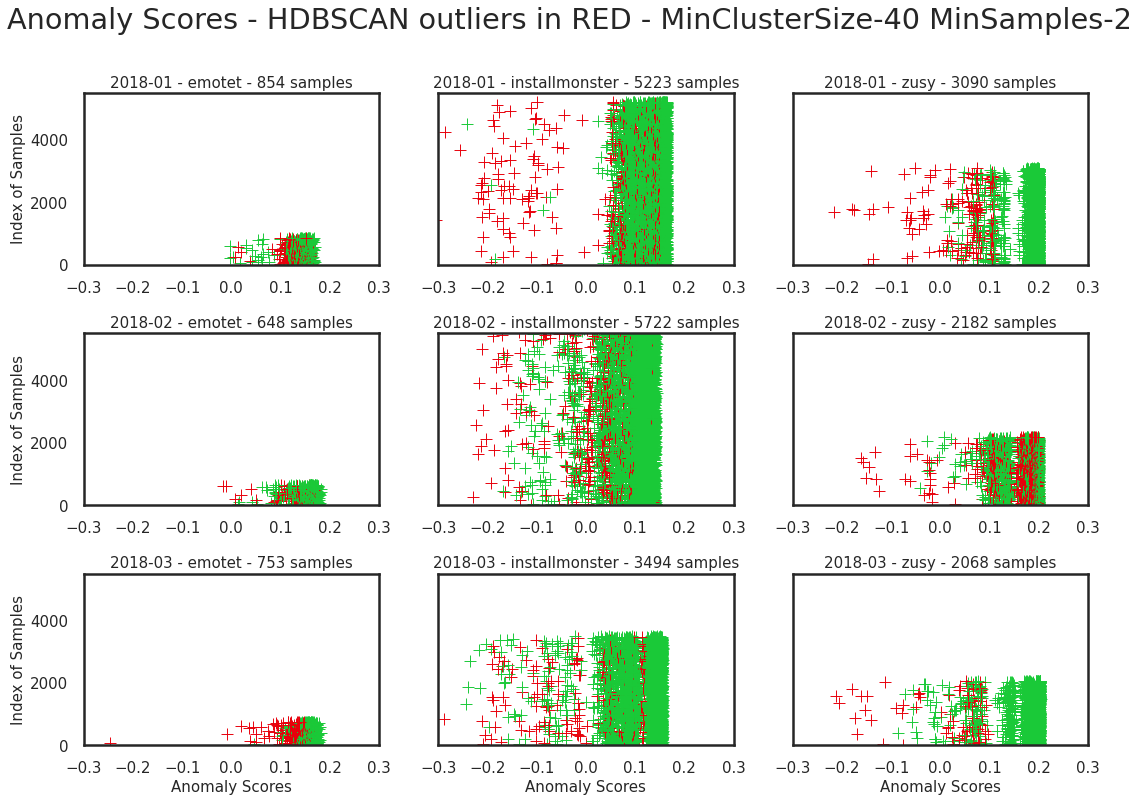

In [75]:
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
palette = sns.color_palette("bright")


save_file_name = f'TASK_IF_HDBSCAN_red_outliers_STD_{mcsize}_{msam}.pdf'
figure, axis = plt.subplots(3, 3, figsize=(18, 12))

figure.suptitle(f'Anomaly Scores - HDBSCAN outliers in RED - MinClusterSize-{mcsize} MinSamples-{msam}')


cluster_colors = [palette[3] if l== -1 else palette[2] for l in labels_00]
sns.scatterplot(ax=axis[0, 0], x=anomaly_00, y=[i for i in range(len(anomaly_00))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[0, 0].set_title(f"{all_task_months[0]} - {top_10[6]} - {len(anomaly_00)} samples", fontsize=15)
axis[0, 0].tick_params(labelsize=15)  
#axis[0, 0].set_xlabel("Anomaly Scores",fontsize=15)    
axis[0, 0].set_ylabel("Index of Samples",fontsize=15)    
axis[0, 0].set_xlim(-0.3, 0.3)
axis[0, 0].set_ylim(0, 5500)


cluster_colors = [palette[3] if l== -1 else palette[2] for l in labels_01]
sns.scatterplot(ax=axis[0, 1], x=anomaly_01, y=[i for i in range(len(anomaly_01))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[0, 1].set_title(f'{all_task_months[0]} - {top_10[4]} - {len(anomaly_01)} samples', fontsize=15)
axis[0, 1].tick_params(labelsize=15, labelleft=False, left=False)  
#axis[0, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[0, 1].set_ylabel(" ",fontsize=15)    
axis[0, 1].set_xlim(-0.3, 0.3)  
axis[0, 1].set_ylim(0, 5500)


cluster_colors = [palette[3] if l== -1 else palette[2] for l in labels_02]
sns.scatterplot(ax=axis[0, 2], x=anomaly_02, y=[i for i in range(len(anomaly_02))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[0, 2].set_title(f'{all_task_months[0]} - {top_10[5]} - {len(anomaly_02)} samples', fontsize=15)
axis[0, 2].tick_params(labelsize=15, labelleft=False, left=False)  
#axis[0, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[0, 2].set_ylabel(" ",fontsize=15)    
axis[0, 2].set_xlim(-0.3, 0.3)
axis[0, 2].set_ylim(0, 5500)


cluster_colors = [palette[3] if l== -1 else palette[2] for l in labels_10]
sns.scatterplot(ax=axis[1, 0], x=anomaly_10, y=[i for i in range(len(anomaly_10))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[1, 0].set_title(f'{all_task_months[1]} - {top_10[6]} - {len(anomaly_10)} samples', fontsize=15)
axis[1, 0].tick_params(labelsize=15)  
#axis[1, 0].set_xlabel("Anomaly Scores",fontsize=15)    
axis[1, 0].set_ylabel("Index of Samples",fontsize=15) 
axis[1, 0].set_xlim(-0.3, 0.3)
axis[1, 0].set_ylim(0, 5500)


cluster_colors = [palette[3] if l== -1 else palette[2] for l in labels_11]
sns.scatterplot(ax=axis[1, 1], x=anomaly_11, y=[i for i in range(len(anomaly_11))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[1, 1].set_title(f'{all_task_months[1]} - {top_10[4]} - {len(anomaly_11)} samples', fontsize=15)
axis[1, 1].tick_params(labelsize=15, labelleft=False, left=False)  
#axis[1, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[1, 1].set_ylabel(" ",fontsize=15) 
axis[1, 1].set_xlim(-0.3, 0.3)  
axis[1, 1].set_ylim(0, 5500)


cluster_colors = [palette[3] if l== -1 else palette[2] for l in labels_12]
sns.scatterplot(ax=axis[1, 2], x=anomaly_12, y=[i for i in range(len(anomaly_12))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[1, 2].set_title(f'{all_task_months[1]} - {top_10[5]} - {len(anomaly_12)} samples', fontsize=15)
axis[1, 2].tick_params(labelsize=15, labelleft=False, left=False)  
#axis[1, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[1, 2].set_ylabel(" ",fontsize=15) 
axis[1, 2].set_xlim(-0.3, 0.3)
axis[1, 2].set_ylim(0, 5500)

cluster_colors = [palette[3] if l== -1 else palette[2] for l in labels_20]
sns.scatterplot(ax=axis[2, 0], x=anomaly_20, y=[i for i in range(len(anomaly_20))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[2, 0].set_title(f'{all_task_months[2]} - {top_10[6]} - {len(anomaly_20)} samples', fontsize=15)
axis[2, 0].tick_params(labelsize=15)  
axis[2, 0].set_xlabel("Anomaly Scores",fontsize=15)    
axis[2, 0].set_ylabel("Index of Samples",fontsize=15) 
axis[2, 0].set_xlim(-0.3, 0.3)
axis[2, 0].set_ylim(0, 5500)


cluster_colors = [palette[3] if l== -1 else palette[2] for l in labels_21]
sns.scatterplot(ax=axis[2, 1], x=anomaly_21, y=[i for i in range(len(anomaly_21))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[2, 1].set_title(f'{all_task_months[2]} - {top_10[4]} - {len(anomaly_21)} samples', fontsize=15)
axis[2, 1].tick_params(labelsize=15, labelleft=False, left=False)  
axis[2, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[2, 1].set_ylabel(" ",fontsize=15) 
axis[2, 1].set_xlim(-0.3, 0.3)
axis[2, 1].set_ylim(0, 5500)

cluster_colors = [palette[3] if l== -1 else palette[2] for l in labels_22]
sns.scatterplot(ax=axis[2, 2], x=anomaly_22, y=[i for i in range(len(anomaly_22))],\
                c=cluster_colors, marker='+',  alpha=1.0)
axis[2, 2].set_title(f'{all_task_months[2]} - {top_10[5]} - {len(anomaly_22)} samples', fontsize=15)
axis[2, 2].tick_params(labelsize=15, labelleft=False, left=False)  
axis[2, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[2, 2].set_ylabel(" ",fontsize=15) 
axis[2, 2].set_xlim(-0.3, 0.3)
axis[2, 2].set_ylim(0, 5500)



plt.subplots_adjust(hspace = 0.4)

plt.savefig('./figures/isolation_forest/' + save_file_name, bbox_inches='tight', dpi=1000);


## tSNE projections - Colors w/ HDBSCAN labels

In [53]:
def get_tSNE(task_id, family_ind, task_families_data, components):
    top_10 = ['xtrat', 'zbot', 'ramnit', 'sality', 'installmonster',\
              'zusy', 'emotet', 'vtflooder', 'others_family', 'fareit']
    all_task_months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
                   '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12']
    
    curr_task = all_task_months[task_id]
    family_name = top_10[family_ind]

    print(f'task {curr_task} family name {family_name}')
    data_X = task_families_data[task_id][family_name]
    #print(type(data_X))
    data_X = np.array(data_X)
    #print(type(data_X))
    tsne = TSNE(n_components=components, random_state=123)
    tsne_d = tsne.fit_transform(data_X)

    return tsne_d


In [65]:
tSNE_00 = get_tSNE(0, 6, malware_family_samples, 2)
tSNE_01 = get_tSNE(0, 4, malware_family_samples, 2)
tSNE_02 = get_tSNE(0, 5, malware_family_samples, 2)

tSNE_10 = get_tSNE(1, 6, malware_family_samples, 2)
tSNE_11 = get_tSNE(1, 4, malware_family_samples, 2)
tSNE_12 = get_tSNE(1, 5, malware_family_samples, 2)

tSNE_20 = get_tSNE(2, 6, malware_family_samples, 2)
tSNE_21 = get_tSNE(2, 4, malware_family_samples, 2)
tSNE_22 = get_tSNE(2, 5, malware_family_samples, 2)

task 2018-01 family name emotet
task 2018-01 family name installmonster
task 2018-01 family name zusy
task 2018-02 family name emotet
task 2018-02 family name installmonster
task 2018-02 family name zusy
task 2018-03 family name emotet
task 2018-03 family name installmonster
task 2018-03 family name zusy


In [58]:
tSNE_00_c3 = get_tSNE(0, 6, malware_family_samples, 3)
tSNE_01_c3 = get_tSNE(0, 4, malware_family_samples, 3)
tSNE_02_c3 = get_tSNE(0, 5, malware_family_samples, 3)

tSNE_10_c3 = get_tSNE(1, 6, malware_family_samples, 3)
tSNE_11_c3 = get_tSNE(1, 4, malware_family_samples, 3)
tSNE_12_c3 = get_tSNE(1, 5, malware_family_samples, 3)

tSNE_20_c3 = get_tSNE(2, 6, malware_family_samples, 3)
tSNE_21_c3 = get_tSNE(2, 4, malware_family_samples, 3)
tSNE_22_c3 = get_tSNE(2, 5, malware_family_samples, 3)

task 2018-01 family name emotet
task 2018-01 family name installmonster
task 2018-01 family name zusy
task 2018-02 family name emotet
task 2018-02 family name installmonster
task 2018-02 family name zusy
task 2018-03 family name emotet
task 2018-03 family name installmonster
task 2018-03 family name zusy


/home/mr6564/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'c'
  del sys.path[0]
/home/mr6564/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The following kwargs were not used by contour: 'c'
/home/mr6564/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: The following kwargs were not used by contour: 'c'
/home/mr6564/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: The following kwargs were not used by contour: 'c'
/home/mr6564/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: The following kwargs were not used by contour: 'c'
/home/mr6564/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: The following kwargs were not used by contour: 'c'
/home/mr6564/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: The following kwargs were not used by contour: 'c'
/home/mr6564/.lo

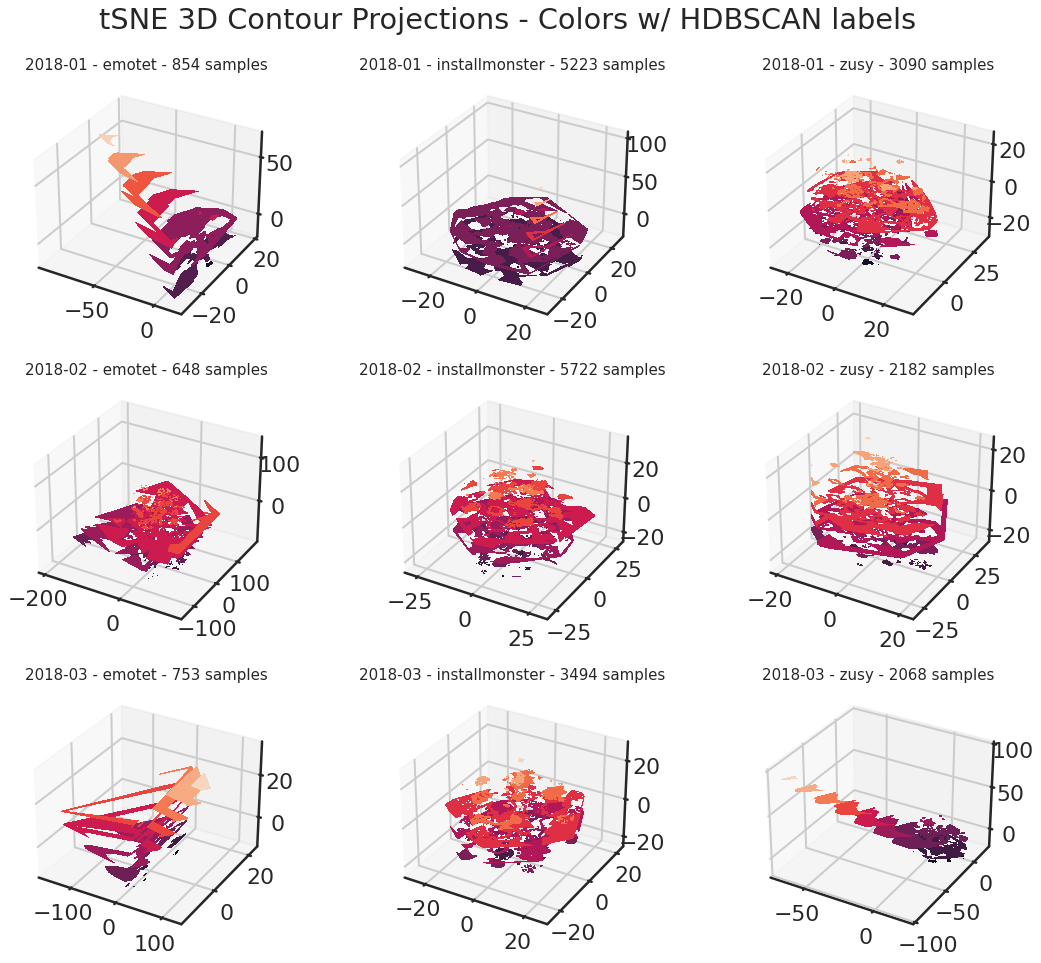

In [59]:
fig, ax = plt.subplots(3,3,figsize=(18,12),subplot_kw=dict(projection='3d'))
#fig, ax = plt.subplots(3,3,figsize=(18,12))
fig.suptitle(f'tSNE 3D Contour Projections - Colors w/ HDBSCAN labels - MinClusterSize-{mcsize} MinSamples-{msam}')


save_file_name = f'TASK_tSNE_Contour_HDBSCAN_STD_{mcsize}_{msam}.pdf'

#fig.tight_layout(pad=1.0)
plt.subplots_adjust(left=0.1, bottom=-.10, right=0.9, top=.9,wspace=0.2, hspace=0.2)

palette = sns.color_palette(sns.color_palette("Dark2", num_labels_00))
cluster_colors = [palette[l] for l in labels_00]
ax[0,0].tricontourf(tSNE_00_c3[:,0], tSNE_00_c3[:,1], tSNE_00_c3[:,2], c=cluster_colors, alpha=1.0)
ax[0,0].set_title(f"{all_task_months[0]} - {top_10[6]} - {len(anomaly_00)} samples", fontsize=15)


palette = sns.color_palette(sns.color_palette("Dark2", num_labels_01))
cluster_colors = [palette[l] for l in labels_01]
ax[0,1].tricontourf(tSNE_01_c3[:,0], tSNE_01_c3[:,1], tSNE_01_c3[:,2], c=cluster_colors, alpha=1.0)
ax[0,1].set_title(f'{all_task_months[0]} - {top_10[4]} - {len(anomaly_01)} samples', fontsize=15)


palette = sns.color_palette(sns.color_palette("Dark2", num_labels_02))
cluster_colors = [palette[l] for l in labels_02]
ax[0,2].tricontourf(tSNE_02_c3[:,0], tSNE_02_c3[:,1], tSNE_02_c3[:,2], c=cluster_colors, alpha=1.0)
ax[0,2].set_title(f'{all_task_months[0]} - {top_10[5]} - {len(anomaly_02)} samples', fontsize=15)


#new line
palette = sns.color_palette(sns.color_palette("Dark2", num_labels_10))
cluster_colors = [palette[l] for l in labels_10]
ax[1,0].tricontourf(tSNE_10_c3[:,0], tSNE_10_c3[:,1], tSNE_10_c3[:,2], c=cluster_colors, alpha=1.0)
ax[1,0].set_title(f'{all_task_months[1]} - {top_10[6]} - {len(anomaly_10)} samples', fontsize=15)


palette = sns.color_palette(sns.color_palette("Dark2", num_labels_11))
cluster_colors = [palette[l] for l in labels_11]
ax[1,1].tricontourf(tSNE_11_c3[:,0], tSNE_11_c3[:,1], tSNE_11_c3[:,2], c=cluster_colors, alpha=1.0)
ax[1,1].set_title(f'{all_task_months[1]} - {top_10[4]} - {len(anomaly_11)} samples', fontsize=15)


palette = sns.color_palette(sns.color_palette("Dark2", num_labels_12))
cluster_colors = [palette[l] for l in labels_12]
ax[1,2].tricontourf(tSNE_12_c3[:,0], tSNE_12_c3[:,1], tSNE_12_c3[:,2], c=cluster_colors, alpha=1.0)
ax[1,2].set_title(f'{all_task_months[1]} - {top_10[5]} - {len(anomaly_12)} samples', fontsize=15)


#new line
palette = sns.color_palette(sns.color_palette("Dark2", num_labels_20))
cluster_colors = [palette[l] for l in labels_20]
ax[2,0].tricontourf(tSNE_20_c3[:,0], tSNE_20_c3[:,1], tSNE_20_c3[:,2], c=cluster_colors, alpha=1.0)
ax[2,0].set_title(f'{all_task_months[2]} - {top_10[6]} - {len(anomaly_20)} samples', fontsize=15)


palette = sns.color_palette(sns.color_palette("Dark2", num_labels_21))
cluster_colors = [palette[l] for l in labels_21]
ax[2,1].tricontourf(tSNE_21_c3[:,0], tSNE_21_c3[:,1], tSNE_21_c3[:,2], c=cluster_colors, alpha=1.0)
ax[2,1].set_title(f'{all_task_months[2]} - {top_10[4]} - {len(anomaly_21)} samples', fontsize=15)


palette = sns.color_palette(sns.color_palette("Dark2", num_labels_22))
cluster_colors = [palette[l] for l in labels_22]
ax[2,2].tricontourf(tSNE_22_c3[:,0], tSNE_22_c3[:,1], tSNE_22_c3[:,2], c=cluster_colors, alpha=1.0)
ax[2,2].set_title(f'{all_task_months[2]} - {top_10[5]} - {len(anomaly_22)} samples', fontsize=15);



plt.savefig('./figures/isolation_forest/' + save_file_name, bbox_inches='tight', dpi=1000);

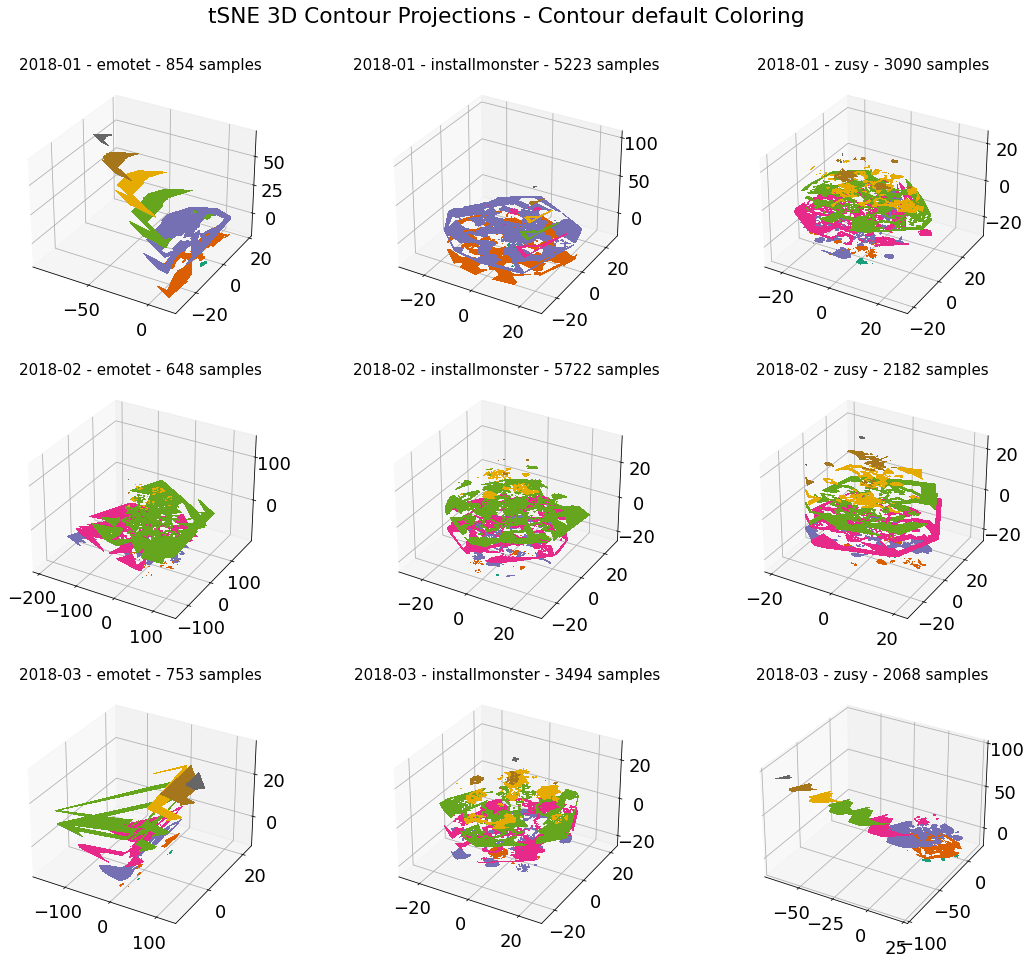

In [95]:
fig, ax = plt.subplots(3,3,figsize=(18,12),subplot_kw=dict(projection='3d'))
#fig, ax = plt.subplots(3,3,figsize=(18,12))
fig.suptitle('tSNE 3D Contour Projections - Contour default Coloring')

Ccmap = 'Dark2'
save_file_name = 'TASK_tSNE_Contour_STD.pdf'

#fig.tight_layout(pad=1.0)
plt.subplots_adjust(left=0.1, bottom=-.10, right=0.9, top=.9,wspace=0.2, hspace=0.2)
ax[0,0].tricontourf(tSNE_00_c3[:,0], tSNE_00_c3[:,1], tSNE_00_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[0,0].set_title(f"{all_task_months[0]} - {top_10[6]} - {len(anomaly_00)} samples", fontsize=15)


ax[0,1].tricontourf(tSNE_01_c3[:,0], tSNE_01_c3[:,1], tSNE_01_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[0,1].set_title(f'{all_task_months[0]} - {top_10[4]} - {len(anomaly_01)} samples', fontsize=15)

ax[0,2].tricontourf(tSNE_02_c3[:,0], tSNE_02_c3[:,1], tSNE_02_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[0,2].set_title(f'{all_task_months[0]} - {top_10[5]} - {len(anomaly_02)} samples', fontsize=15)


#new line
ax[1,0].tricontourf(tSNE_10_c3[:,0], tSNE_10_c3[:,1], tSNE_10_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[1,0].set_title(f'{all_task_months[1]} - {top_10[6]} - {len(anomaly_10)} samples', fontsize=15)

ax[1,1].tricontourf(tSNE_11_c3[:,0], tSNE_11_c3[:,1], tSNE_11_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[1,1].set_title(f'{all_task_months[1]} - {top_10[4]} - {len(anomaly_11)} samples', fontsize=15)

ax[1,2].tricontourf(tSNE_12_c3[:,0], tSNE_12_c3[:,1], tSNE_12_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[1,2].set_title(f'{all_task_months[1]} - {top_10[5]} - {len(anomaly_12)} samples', fontsize=15)


#new line
ax[2,0].tricontourf(tSNE_20_c3[:,0], tSNE_20_c3[:,1], tSNE_20_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[2,0].set_title(f'{all_task_months[2]} - {top_10[6]} - {len(anomaly_20)} samples', fontsize=15)


ax[2,1].tricontourf(tSNE_21_c3[:,0], tSNE_21_c3[:,1], tSNE_21_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[2,1].set_title(f'{all_task_months[2]} - {top_10[4]} - {len(anomaly_21)} samples', fontsize=15)


ax[2,2].tricontourf(tSNE_22_c3[:,0], tSNE_22_c3[:,1], tSNE_22_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[2,2].set_title(f'{all_task_months[2]} - {top_10[5]} - {len(anomaly_22)} samples', fontsize=15);



plt.savefig('./figures/isolation_forest/' + save_file_name, bbox_inches='tight', dpi=1000);

In [39]:
family_ind = 1


# anomaly_02, labels_02, num_labels_02 = get_HDBSCAN_IF_labels_scores(0, family_ind, malware_family_samples)
# anomaly_12, labels_12, num_labels_12 = get_HDBSCAN_IF_labels_scores(1, family_ind, malware_family_samples)
# anomaly_22, labels_22, num_labels_22 = get_HDBSCAN_IF_labels_scores(2, family_ind, malware_family_samples)
# anomaly_32, labels_00, num_labels_00 = get_HDBSCAN_IF_labels_scores(3, family_ind, malware_family_samples)
# anomaly_42, labels_01, num_labels_01 = get_HDBSCAN_IF_labels_scores(4, family_ind, malware_family_samples)
# anomaly_52, labels_10, num_labels_10 = get_HDBSCAN_IF_labels_scores(5, family_ind, malware_family_samples)
# anomaly_62, labels_11, num_labels_11 = get_HDBSCAN_IF_labels_scores(6, family_ind, malware_family_samples)
# anomaly_72, labels_20, num_labels_20 = get_HDBSCAN_IF_labels_scores(7, family_ind, malware_family_samples)
# anomaly_82, labels_21, num_labels_21 = get_HDBSCAN_IF_labels_scores(8, family_ind, malware_family_samples)
# anomaly_92, labels_21, num_labels_21 = get_HDBSCAN_IF_labels_scores(9, family_ind, malware_family_samples)
# anomaly_002, labels_21, num_labels_21 = get_HDBSCAN_IF_labels_scores(10, family_ind, malware_family_samples)
# anomaly_012, labels_21, num_labels_21 = get_HDBSCAN_IF_labels_scores(11, family_ind, malware_family_samples)


tSNE_02_c3 = get_tSNE(0, family_ind, malware_family_samples, 3)
tSNE_12_c3 = get_tSNE(1, family_ind, malware_family_samples, 3)
tSNE_22_c3 = get_tSNE(2, family_ind, malware_family_samples, 3)
tSNE_32_c3 = get_tSNE(3, family_ind, malware_family_samples, 3)
tSNE_42_c3 = get_tSNE(4, family_ind, malware_family_samples, 3)
tSNE_52_c3 = get_tSNE(5, family_ind, malware_family_samples, 3)
tSNE_62_c3 = get_tSNE(6, family_ind, malware_family_samples, 3)
tSNE_72_c3 = get_tSNE(7, family_ind, malware_family_samples, 3)
tSNE_82_c3 = get_tSNE(8, family_ind, malware_family_samples, 3)
tSNE_92_c3 = get_tSNE(9, family_ind, malware_family_samples, 3)
tSNE_002_c3 = get_tSNE(10, family_ind, malware_family_samples, 3)
tSNE_012_c3 = get_tSNE(11, family_ind, malware_family_samples, 3)


task 2018-01 family name zbot
task 2018-02 family name zbot
task 2018-03 family name zbot
task 2018-04 family name zbot
task 2018-05 family name zbot
task 2018-06 family name zbot
task 2018-07 family name zbot
task 2018-08 family name zbot
task 2018-09 family name zbot
task 2018-10 family name zbot
task 2018-11 family name zbot
task 2018-12 family name zbot


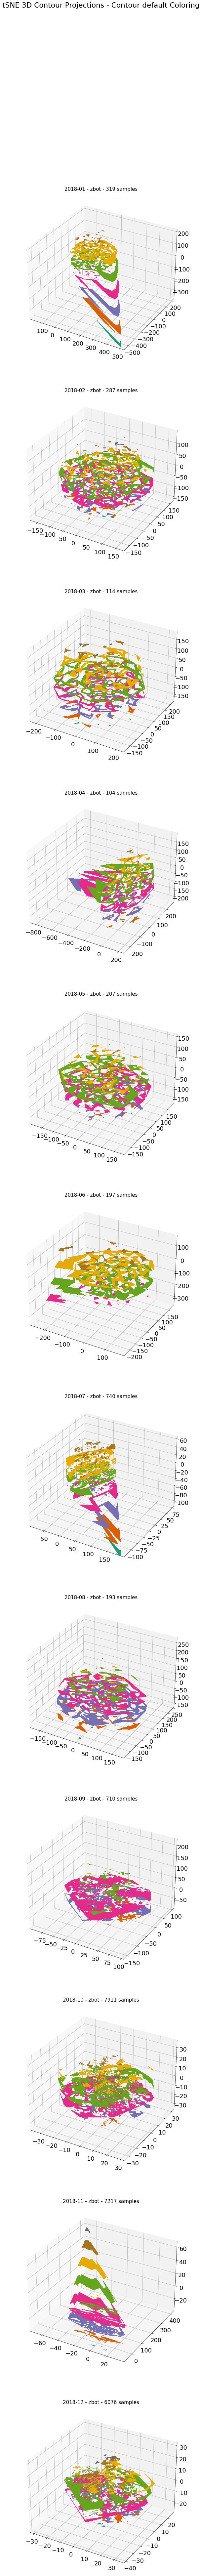

In [48]:
typePlot = '3D'

if typePlot == '3D':
    fig, ax = plt.subplots(12,1,figsize=(80,100),subplot_kw=dict(projection='3d'))
else:
    fig, ax = plt.subplots(12,1,figsize=(8,60))
    
fig.suptitle(f'tSNE {typePlot} Contour Projections - Contour default Coloring')
#fig.tight_layout(pad=.3)
plt.subplots_adjust(left=0.1, bottom=-.10, right=0.9, top=.9,wspace=0.2, hspace=0.2)

Ccmap = 'Dark2'
save_file_name = 'TASK_tSNE_Contour_' + str(top_10[family_ind]) + '_STD_' + typePlot +'.pdf'


#ax[0].tricontour(tSNE_02_c3[:,0], tSNE_02_c3[:,1], tSNE_02_c3[:,2], levels=14, linewidths=0.5, colors='k')
ax[0].tricontourf(tSNE_02_c3[:,0], tSNE_02_c3[:,1], tSNE_02_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[0].set_title(f'{all_task_months[0]} - {top_10[family_ind]} - {len(tSNE_02_c3)} samples', fontsize=15)


#ax[1].tricontour(tSNE_12_c3[:,0], tSNE_12_c3[:,1], tSNE_12_c3[:,2], levels=14, linewidths=0.5, colors='k')
ax[1].tricontourf(tSNE_12_c3[:,0], tSNE_12_c3[:,1], tSNE_12_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[1].set_title(f'{all_task_months[1]} - {top_10[family_ind]} - {len(tSNE_12_c3)} samples', fontsize=15)


#ax[2].tricontour(tSNE_22_c3[:,0], tSNE_22_c3[:,1], tSNE_22_c3[:,2], levels=14, linewidths=0.5, colors='k')
ax[2].tricontourf(tSNE_22_c3[:,0], tSNE_22_c3[:,1], tSNE_22_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[2].set_title(f'{all_task_months[2]} - {top_10[family_ind]} - {len(tSNE_22_c3)} samples', fontsize=15);


#ax[3].tricontour(tSNE_32_c3[:,0], tSNE_32_c3[:,1], tSNE_32_c3[:,2], levels=14, linewidths=0.5, colors='k')
ax[3].tricontourf(tSNE_32_c3[:,0], tSNE_32_c3[:,1], tSNE_32_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[3].set_title(f'{all_task_months[3]} - {top_10[family_ind]} - {len(tSNE_32_c3)} samples', fontsize=15);


#ax[4].tricontour(tSNE_42_c3[:,0], tSNE_42_c3[:,1], tSNE_42_c3[:,2], levels=14, linewidths=0.5, colors='k')
ax[4].tricontourf(tSNE_42_c3[:,0], tSNE_42_c3[:,1], tSNE_42_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[4].set_title(f'{all_task_months[4]} - {top_10[family_ind]} - {len(tSNE_42_c3)} samples', fontsize=15);

#ax[5].tricontour(tSNE_52_c3[:,0], tSNE_52_c3[:,1], tSNE_52_c3[:,2], levels=14, linewidths=0.5, colors='k')
ax[5].tricontourf(tSNE_52_c3[:,0], tSNE_52_c3[:,1], tSNE_52_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[5].set_title(f'{all_task_months[5]} - {top_10[family_ind]} - {len(tSNE_52_c3)} samples', fontsize=15);

#ax[6].tricontour(tSNE_62_c3[:,0], tSNE_62_c3[:,1], tSNE_62_c3[:,2], levels=14, linewidths=0.5, colors='k')
ax[6].tricontourf(tSNE_62_c3[:,0], tSNE_62_c3[:,1], tSNE_62_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[6].set_title(f'{all_task_months[6]} - {top_10[family_ind]} - {len(tSNE_62_c3)} samples', fontsize=15);


#ax[7].tricontour(tSNE_72_c3[:,0], tSNE_72_c3[:,1], tSNE_72_c3[:,2], levels=14, linewidths=0.5, colors='k')
ax[7].tricontourf(tSNE_72_c3[:,0], tSNE_72_c3[:,1], tSNE_72_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[7].set_title(f'{all_task_months[7]} - {top_10[family_ind]} - {len(tSNE_72_c3)} samples', fontsize=15);


#ax[8].tricontour(tSNE_82_c3[:,0], tSNE_82_c3[:,1], tSNE_82_c3[:,2], levels=14, linewidths=0.5, colors='k')
ax[8].tricontourf(tSNE_82_c3[:,0], tSNE_82_c3[:,1], tSNE_82_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[8].set_title(f'{all_task_months[8]} - {top_10[family_ind]} - {len(tSNE_82_c3)} samples', fontsize=15);


#ax[9].tricontour(tSNE_92_c3[:,0], tSNE_92_c3[:,1], tSNE_92_c3[:,2], levels=14, linewidths=0.5, colors='k')
ax[9].tricontourf(tSNE_92_c3[:,0], tSNE_92_c3[:,1], tSNE_92_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[9].set_title(f'{all_task_months[9]} - {top_10[family_ind]} - {len(tSNE_92_c3)} samples', fontsize=15);

#ax[10].tricontour(tSNE_002_c3[:,0], tSNE_002_c3[:,1], tSNE_002_c3[:,2], levels=14, linewidths=0.5, colors='k')
ax[10].tricontourf(tSNE_002_c3[:,0], tSNE_002_c3[:,1], tSNE_002_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[10].set_title(f'{all_task_months[10]} - {top_10[family_ind]} - {len(tSNE_002_c3)} samples', fontsize=15);

#ax[11].tricontour(tSNE_012_c3[:,0], tSNE_012_c3[:,1], tSNE_012_c3[:,2], levels=14, linewidths=0.5, colors='k')
ax[11].tricontourf(tSNE_012_c3[:,0], tSNE_012_c3[:,1], tSNE_012_c3[:,2], cmap=Ccmap, alpha=1.0)
ax[11].set_title(f'{all_task_months[11]} - {top_10[family_ind]} - {len(tSNE_012_c3)} samples', fontsize=15);


#plt.savefig('./figures/isolation_forest/' + save_file_name, bbox_inches='tight', dpi=1000);

### tSNE 2D Plot

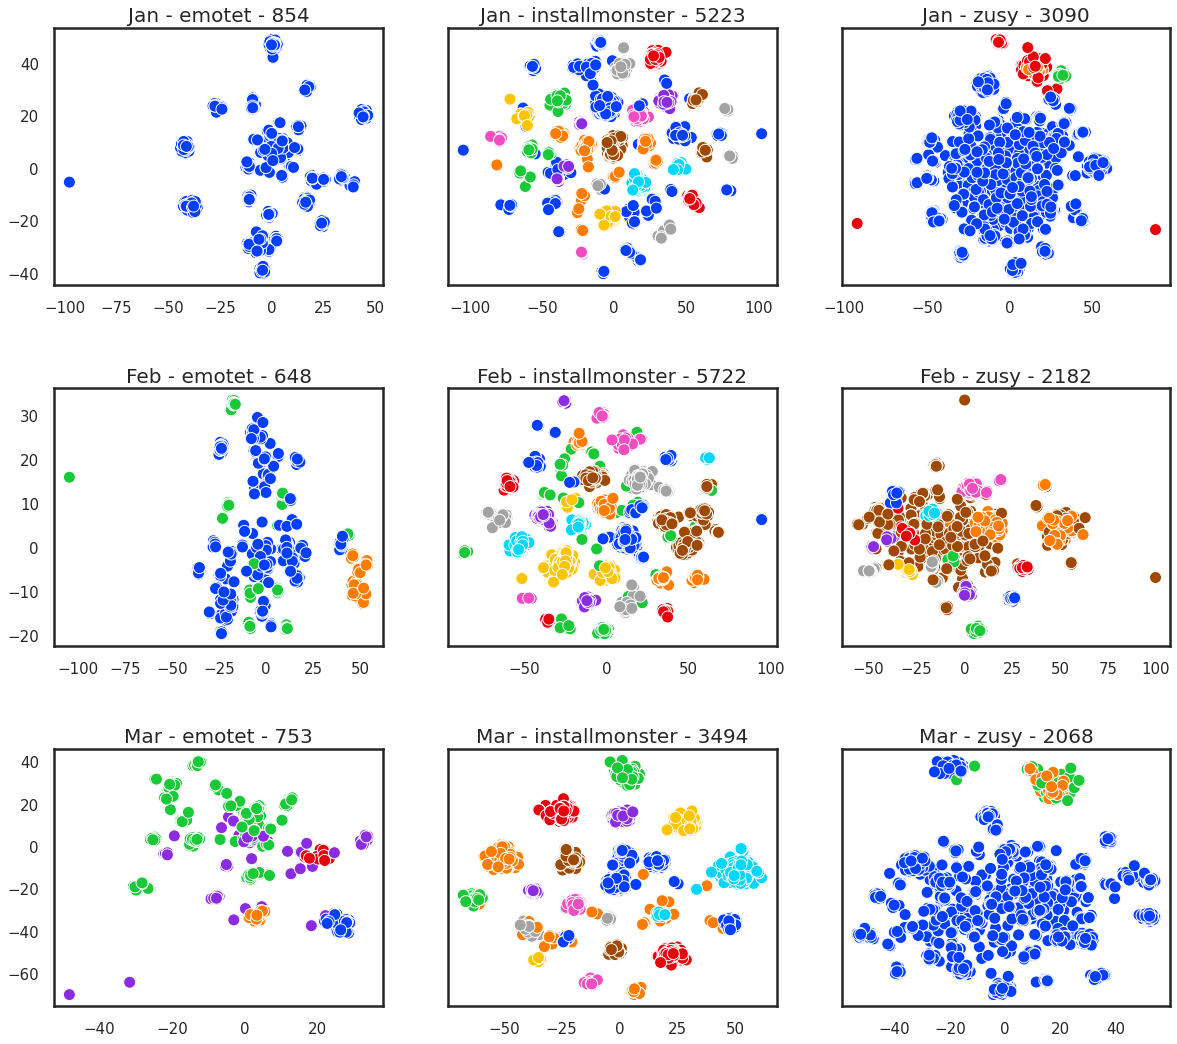

In [91]:
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
palette = sns.color_palette("bright")


save_file_name = f'TASK_tSNE_colors_HDBSCAN_STD_{mcsize}_{msam}.png'
figure, axis = plt.subplots(3, 3, figsize=(20, 18))

#figure.suptitle(f'tSNE Projections - Colors w/ HDBSCAN labels - MinClusterSize-{mcsize} MinSamples-{msam}')

all_task_months = ['Jan', 'Feb', 'Mar']

palette = sns.color_palette(sns.color_palette("bright", num_labels_00))
cluster_colors = [palette[l] for l in labels_00]
sns.scatterplot(ax=axis[0, 0], x=tSNE_00[:,0], y=tSNE_00[:,1], c=cluster_colors,  alpha=1.0)
axis[0, 0].set_title(f"{all_task_months[0]} - {top_10[6]} - {len(anomaly_00)}", fontsize=20)
axis[0, 0].tick_params(labelsize=15)  
#axis[0, 0].set_xlabel("Anomaly Scores",fontsize=15)    
#axis[0, 0].set_ylabel("Index of Samples",fontsize=15)    
#axis[0, 0].set_xlim(-0.3, 0.3)
#axis[0, 0].set_ylim(0, 5500)


palette = sns.color_palette(sns.color_palette("bright", num_labels_01))
cluster_colors = [palette[l] for l in labels_01]
sns.scatterplot(ax=axis[0, 1], x=tSNE_01[:,0], y=tSNE_01[:,1], c=cluster_colors,  alpha=1.0)
axis[0, 1].set_title(f'{all_task_months[0]} - {top_10[4]} - {len(anomaly_01)}', fontsize=20)
axis[0, 1].tick_params(labelsize=15, labelleft=False, left=False)  
#axis[0, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[0, 1].set_ylabel(" ",fontsize=15)    
#axis[0, 1].set_xlim(-0.3, 0.3)  
#axis[0, 1].set_ylim(0, 5500)


palette = sns.color_palette(sns.color_palette("bright", num_labels_02))
cluster_colors = [palette[l] for l in labels_02]
sns.scatterplot(ax=axis[0, 2], x=tSNE_02[:,0], y=tSNE_02[:,1], c=cluster_colors,  alpha=1.0)
axis[0, 2].set_title(f'{all_task_months[0]} - {top_10[5]} - {len(anomaly_02)}', fontsize=20)
axis[0, 2].tick_params(labelsize=15, labelleft=False, left=False)  
#axis[0, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[0, 2].set_ylabel(" ",fontsize=15)    
#axis[0, 2].set_xlim(-0.3, 0.3)
#axis[0, 2].set_ylim(0, 5500)


palette = sns.color_palette(sns.color_palette("bright", num_labels_10))
cluster_colors = [palette[l] for l in labels_10]
sns.scatterplot(ax=axis[1, 0], x=tSNE_10[:,0], y=tSNE_10[:,1], c=cluster_colors,  alpha=1.0)
axis[1, 0].set_title(f'{all_task_months[1]} - {top_10[6]} - {len(anomaly_10)}', fontsize=20)
axis[1, 0].tick_params(labelsize=15)  
#axis[1, 0].set_xlabel("Anomaly Scores",fontsize=15)    
#axis[1, 0].set_ylabel("Index of Samples",fontsize=15) 
#axis[1, 0].set_xlim(-0.3, 0.3)
#axis[1, 0].set_ylim(0, 5500)


palette = sns.color_palette(sns.color_palette("bright", num_labels_11))
cluster_colors = [palette[l] for l in labels_11]
sns.scatterplot(ax=axis[1, 1], x=tSNE_11[:,0], y=tSNE_11[:,1], c=cluster_colors,  alpha=1.0)
axis[1, 1].set_title(f'{all_task_months[1]} - {top_10[4]} - {len(anomaly_11)}', fontsize=20)
axis[1, 1].tick_params(labelsize=15, labelleft=False, left=False)  
#axis[1, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[1, 1].set_ylabel(" ",fontsize=15) 
#axis[1, 1].set_xlim(-0.3, 0.3)  
#axis[1, 1].set_ylim(0, 5500)


palette = sns.color_palette(sns.color_palette("bright", num_labels_12))
cluster_colors = [palette[l] for l in labels_12]
sns.scatterplot(ax=axis[1, 2], x=tSNE_12[:,0], y=tSNE_12[:,1], c=cluster_colors,  alpha=1.0)
axis[1, 2].set_title(f'{all_task_months[1]} - {top_10[5]} - {len(anomaly_12)}', fontsize=20)
axis[1, 2].tick_params(labelsize=15, labelleft=False, left=False)  
#axis[1, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[1, 2].set_ylabel(" ",fontsize=15) 
#axis[1, 2].set_xlim(-0.3, 0.3)
#axis[1, 2].set_ylim(0, 5500)

palette = sns.color_palette(sns.color_palette("bright", num_labels_20))
cluster_colors = [palette[l] for l in labels_20]
sns.scatterplot(ax=axis[2, 0], x=tSNE_20[:,0], y=tSNE_20[:,1], c=cluster_colors,  alpha=1.0)
axis[2, 0].set_title(f'{all_task_months[2]} - {top_10[6]} - {len(anomaly_20)}', fontsize=20)
axis[2, 0].tick_params(labelsize=15)  
#axis[2, 0].set_xlabel("Anomaly Scores",fontsize=15)    
#axis[2, 0].set_ylabel("Index of Samples",fontsize=15) 
#axis[2, 0].set_xlim(-0.3, 0.3)
#axis[2, 0].set_ylim(0, 5500)


palette = sns.color_palette(sns.color_palette("bright", num_labels_21))
cluster_colors = [palette[l] for l in labels_21]
sns.scatterplot(ax=axis[2, 1], x=tSNE_21[:,0], y=tSNE_21[:,1], c=cluster_colors, alpha=1.0)
axis[2, 1].set_title(f'{all_task_months[2]} - {top_10[4]} - {len(anomaly_21)}', fontsize=20)
axis[2, 1].tick_params(labelsize=15, labelleft=False, left=False)  
#axis[2, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[2, 1].set_ylabel(" ",fontsize=15) 
#axis[2, 1].set_xlim(-0.3, 0.3)
#axis[2, 1].set_ylim(0, 5500)

palette = sns.color_palette(sns.color_palette("bright", num_labels_22))
cluster_colors = [palette[l] for l in labels_22]
sns.scatterplot(ax=axis[2, 2], x=tSNE_22[:,0], y=tSNE_22[:,1], c=cluster_colors,  alpha=1.0)
axis[2, 2].set_title(f'{all_task_months[2]} - {top_10[5]} - {len(anomaly_22)}', fontsize=20)
axis[2, 2].tick_params(labelsize=15, labelleft=False, left=False)  
#axis[2, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[2, 2].set_ylabel(" ",fontsize=15) 
#axis[2, 2].set_xlim(-0.3, 0.3)
#axis[2, 2].set_ylim(0, 5500)



plt.subplots_adjust(hspace = 0.4)

plt.savefig('./figs_proposal/' + save_file_name, bbox_inches='tight', dpi=300);


### tSNE 3D Plot

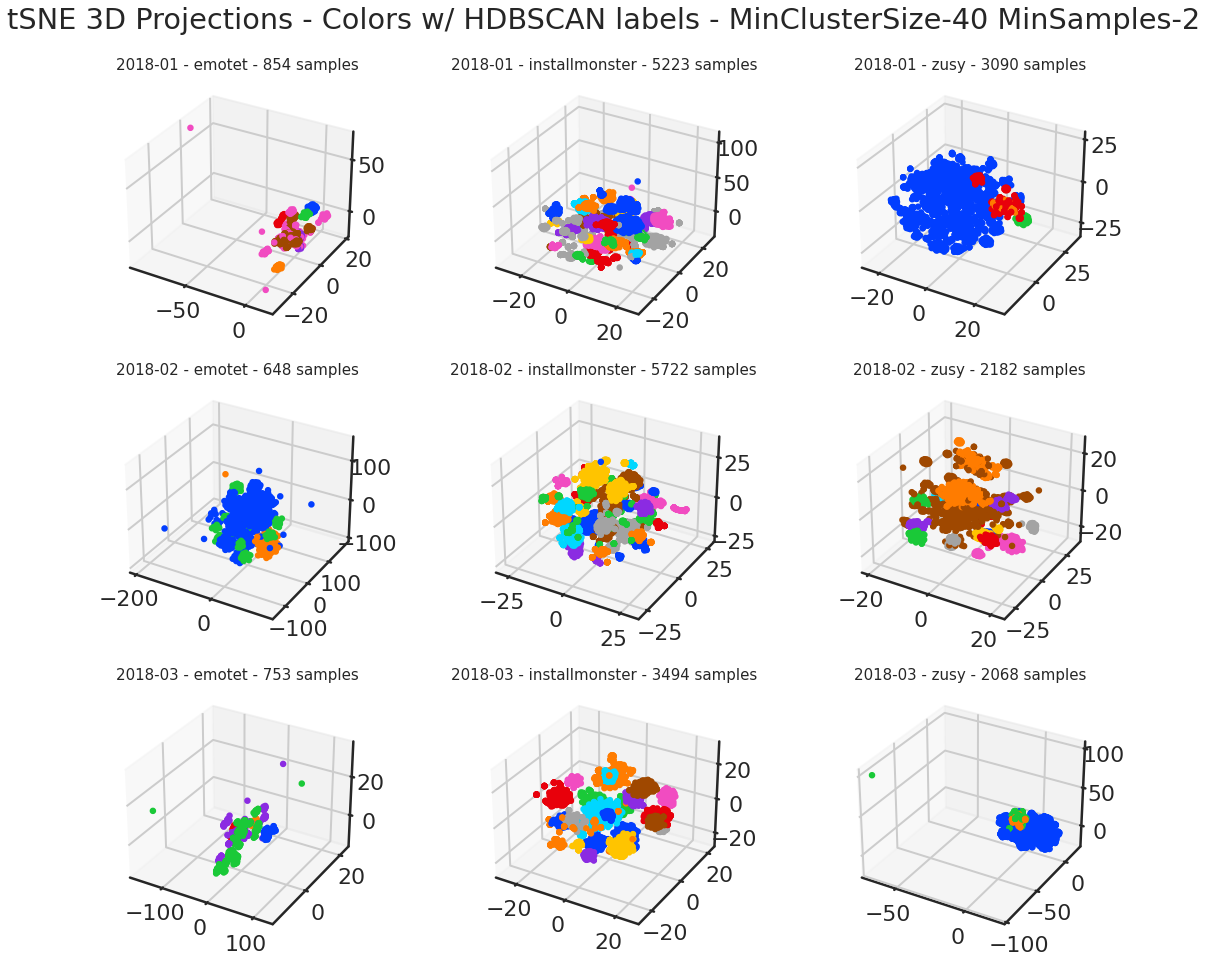

In [77]:
fig, ax = plt.subplots(3,3,figsize=(18,12),subplot_kw=dict(projection='3d'))
fig.suptitle(f'tSNE 3D Projections - Colors w/ HDBSCAN labels - MinClusterSize-{mcsize} MinSamples-{msam}')


save_file_name = f'TASK_tSNE_3D_colors_HDBSCAN_STD_{mcsize}_{msam}.pdf'

#fig.tight_layout(pad=1.0)
plt.subplots_adjust(left=0.1, bottom=-.10, right=0.9, top=.9,wspace=0.2, hspace=0.2)

palette = sns.color_palette(sns.color_palette("bright", num_labels_00))
cluster_colors = [palette[l] for l in labels_00]
ax[0,0].scatter(tSNE_00_c3[:,0], tSNE_00_c3[:,1], tSNE_00_c3[:,2], c=cluster_colors, alpha=1.0)
ax[0,0].set_title(f"{all_task_months[0]} - {top_10[6]} - {len(anomaly_00)} samples", fontsize=15)


palette = sns.color_palette(sns.color_palette("bright", num_labels_01))
cluster_colors = [palette[l] for l in labels_01]
ax[0,1].scatter(tSNE_01_c3[:,0], tSNE_01_c3[:,1], tSNE_01_c3[:,2], c=cluster_colors, alpha=1.0)
ax[0,1].set_title(f'{all_task_months[0]} - {top_10[4]} - {len(anomaly_01)} samples', fontsize=15)


palette = sns.color_palette(sns.color_palette("bright", num_labels_02))
cluster_colors = [palette[l] for l in labels_02]
ax[0,2].scatter(tSNE_02_c3[:,0], tSNE_02_c3[:,1], tSNE_02_c3[:,2], c=cluster_colors, alpha=1.0)
ax[0,2].set_title(f'{all_task_months[0]} - {top_10[5]} - {len(anomaly_02)} samples', fontsize=15)


#new line
palette = sns.color_palette(sns.color_palette("bright", num_labels_10))
cluster_colors = [palette[l] for l in labels_10]
ax[1,0].scatter(tSNE_10_c3[:,0], tSNE_10_c3[:,1], tSNE_10_c3[:,2], c=cluster_colors, alpha=1.0)
ax[1,0].set_title(f'{all_task_months[1]} - {top_10[6]} - {len(anomaly_10)} samples', fontsize=15)


palette = sns.color_palette(sns.color_palette("bright", num_labels_11))
cluster_colors = [palette[l] for l in labels_11]
ax[1,1].scatter(tSNE_11_c3[:,0], tSNE_11_c3[:,1], tSNE_11_c3[:,2], c=cluster_colors, alpha=1.0)
ax[1,1].set_title(f'{all_task_months[1]} - {top_10[4]} - {len(anomaly_11)} samples', fontsize=15)


palette = sns.color_palette(sns.color_palette("bright", num_labels_12))
cluster_colors = [palette[l] for l in labels_12]
ax[1,2].scatter(tSNE_12_c3[:,0], tSNE_12_c3[:,1], tSNE_12_c3[:,2], c=cluster_colors, alpha=1.0)
ax[1,2].set_title(f'{all_task_months[1]} - {top_10[5]} - {len(anomaly_12)} samples', fontsize=15)


#new line
palette = sns.color_palette(sns.color_palette("bright", num_labels_20))
cluster_colors = [palette[l] for l in labels_20]
ax[2,0].scatter(tSNE_20_c3[:,0], tSNE_20_c3[:,1], tSNE_20_c3[:,2], c=cluster_colors, alpha=1.0)
ax[2,0].set_title(f'{all_task_months[2]} - {top_10[6]} - {len(anomaly_20)} samples', fontsize=15)


palette = sns.color_palette(sns.color_palette("bright", num_labels_21))
cluster_colors = [palette[l] for l in labels_21]
ax[2,1].scatter(tSNE_21_c3[:,0], tSNE_21_c3[:,1], tSNE_21_c3[:,2], c=cluster_colors, alpha=1.0)
ax[2,1].set_title(f'{all_task_months[2]} - {top_10[4]} - {len(anomaly_21)} samples', fontsize=15)


palette = sns.color_palette(sns.color_palette("bright", num_labels_22))
cluster_colors = [palette[l] for l in labels_22]
ax[2,2].scatter(tSNE_22_c3[:,0], tSNE_22_c3[:,1], tSNE_22_c3[:,2], c=cluster_colors, alpha=1.0)
ax[2,2].set_title(f'{all_task_months[2]} - {top_10[5]} - {len(anomaly_22)} samples', fontsize=15);



plt.savefig('./figures/isolation_forest/' + save_file_name, bbox_inches='tight', dpi=1000);

## KDE Plot of Anomaly Scores